### Q.5B

Fetch data from google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Import libraries

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from keras.layers import SimpleRNN,LSTM,GRU,Embedding,Dense,Dropout,Input,Concatenate
from tensorflow.keras.optimizers import Adam,Nadam
from keras import Model

Data pre-processing

In [39]:
# token mapping
def tok_map(data):
    source = data['en'].values
    target = data['hi'].values
    target = '\t'+target+'\n'

    len_list_s = [len(i) for i in source]
    s_max_len = max(len_list_s)

    len_list_t = [len(i) for i in target]
    t_max_len = max(len_list_t)

    # creating tokens of source language
    s_tok = set()
    for sw in source:
        for chr in sw:
            s_tok.add(chr)
    source_tokens = sorted(list(s_tok))
    s_tok_map = dict([(chr,i+1) for i,chr in enumerate(source_tokens)])
    s_tok_map[" "] = 0

    # creating tokens of target language
    t_tok = set()
    for st in target:
        for chr in st:
            t_tok.add(chr)
    tar_tokens = sorted(list(t_tok))
    t_tok_map = dict([(chr,i+1) for i,chr in enumerate(tar_tokens)])
    t_tok_map[" "] = 0

    return source_tokens, s_tok_map, s_max_len, tar_tokens, t_tok_map, t_max_len


# load the data given the path
def dataLoad(path):
    with open(path) as dataFile:
        dataset = pd.read_csv(dataFile,sep='\t',header=None,names=["hi","en",""],skip_blank_lines=True,index_col=None)
    dataset = dataset[dataset['hi'].notna()]
    dataset = dataset[dataset['en'].notna()]
    dataset = dataset[['hi','en']]
    return dataset

# create inputs for encoder & decoder and target for decoder
def dataProcess(data):
    src,tar = data['en'].values, data['hi'].values
    tar = "\t" + tar + "\n"

    slen = len(src)
    enc_inp = np.zeros(
        (slen,s_max_len), dtype="float32"
    )

    tlen = len(tar)
    dec_inp = np.zeros(
        (tlen,t_max_len), dtype="float32"
    )
    dec_tar = np.zeros(
        (tlen, t_max_len, len(tar_tokens)+1), dtype="int"
    )

    for i,(sw,tw) in enumerate(zip(src,tar)):
        # encoder input
        for j,ch in enumerate(sw):
            enc_inp[i,j] = s_tok_map[ch]
        enc_inp[i,j+1:] = s_tok_map[" "]

        # decoder input
        for j,ch in enumerate(tw):
            dec_inp[i,j] = t_tok_map[ch]
            if j>0:
                dec_tar[i,j-1,t_tok_map[ch]] = 1

        # decoder target
        dec_inp[i,j+1:] = t_tok_map[" "]
        dec_tar[i,j:,t_tok_map[" "]] = 1
        
    return enc_inp, dec_inp, dec_tar

In [116]:
train = dataLoad("/content/gdrive/MyDrive/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv")
source_tokens, s_tok_map, s_max_len, tar_tokens, t_tok_map, t_max_len = tok_map(train)
dev = dataLoad("/content/gdrive/MyDrive/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv")
test = dataLoad("/content/gdrive/MyDrive/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv")  

In [117]:
# Process the training data
train_encoder_input, train_decoder_input, train_decoder_target = dataProcess(train)

# Process the validation data
val_encoder_input, val_decoder_input, val_decoder_target = dataProcess(dev)

# Process the test data
test_encoder_input, test_decoder_input, test_decoder_target= dataProcess(test)

In [42]:
np.random.seed(42)

In [140]:
# Attention mechanism
class Attention(tf.keras.layers.Layer):
    def __init__(self, units,name=None, **kwargs):
        super(Attention, self).__init__(name=name)
        self.W1 = Dense(units,name='w1')
        self.W2 = Dense(units,name='w2')
        self.V = Dense(1,name='v')
        self.units = units
        super(Attention, self).__init__(**kwargs)

    def call(self, tup):
        #calculate the score
        score = self.V(tf.nn.tanh(self.W1(tf.expand_dims(tup[0], 1)) + self.W2(tup[1])))

        # attention weights
        weights = tf.nn.softmax(score, axis=1)

        # context vector
        vector = tf.reduce_sum( weights *  tup[1], axis=1)
        
        return vector, weights

In [139]:
# to calculate accuracy
def accuracy1(true,pred):
    mask = tf.cast(tf.math.logical_not(tf.math.equal(true, 0)), dtype='int32')
    acc = tf.cast(tf.math.equal(tf.math.argmax(true,axis=2),tf.math.argmax(pred,axis=2)), dtype='int32')
    acc = tf.cast(tf.math.equal(tf.reduce_sum(tf.math.multiply(acc,mask),axis=1),tf.reduce_sum(mask,axis=1)), dtype='float32')
    return (tf.reduce_mean(acc))

Inference

In [137]:
# load the saved model
keras.backend.clear_session()
model = keras.models.load_model('/content/gdrive/MyDrive/best_model_with_att.h5',custom_objects={'accuracy1':accuracy1,'Attention':Attention})

In [138]:
# prepare encoder and decoder for prediction
def build_enc_dec(model,nunits=32,encl=1,decl=1,Layer='LSTM',dropout=None):
    keras.backend.clear_session()

    # prepare encoder 
    enc_inps = model.input[0]
    enc_emb = model.get_layer('enc_embed')
    
    enc_old = [model.get_layer(f'enc_{i}') for i in range(encl-1)]
    enc_final = model.get_layer(f'enc_{encl-1}')
    encop = enc_emb(enc_inps)
    for i,lay in enumerate(enc_old):
        encop = lay(encop)
        if dropout is not None:
            encop = model.get_layer(f'do_{i}')(encop)
     
    # for LSTM
    if Layer == "LSTM":
        o, state_h,state_c = enc_final(encop)
        enc_final = [o,state_h,state_c]
        
    # for GRU
    elif Layer == "GRU":
        o, state = enc_final(encop)
        enc_final = [o,state]

    enc = keras.models.Model(enc_inps,enc_final)
    print("Encoder : Done")
    
    # prepare encoder 
    dec_old = [model.get_layer(f'dec_{i}') for i in range(decl)]
    att = model.get_layer('attention')
    concat1 = model.get_layer('concat1')
    dec_inps = model.input[1]
    dec_emb = model.get_layer('dec_embed')
    decoc = dec_emb(dec_inps)
    
    # for LSTM
    if Layer == "LSTM":
        state_inputs = []
        state_outputs = []
        
        enc_oi = Input(shape=(None,nunits),name='inputenc')
        
        decop = decoc[:,-1:,:]
                                                                  
        for i in range(decl):
            dec_h = Input(shape=(nunits,),name=f"inputh{i}")
            dec_c = Input(shape=(nunits,),name=f"inputc{i}")
            
            if i==0:
                tup = (dec_h,enc_oi)
                context,weights = att(tup)
                decop = concat1([tf.expand_dims(context, 1), decop])
                
            decop,sh,sc = dec_old[i](decop,initial_state = [dec_h,dec_c])
            state_inputs += [dec_h,dec_c]
            state_outputs += [sh,sc]
            
        dec_pass = [dec_inps,enc_oi] + state_inputs

    # for GRU
    elif Layer == "GRU":
        state_inputs = []
        state_outputs = []
        
        enc_oi = Input(shape=(None,nunits),name='inputenc')
        
        decop = decoc[:,:1,:]
                                                                  
        for i in range(decl):
            state_input = Input(shape=(nunits,),name=f"inputs{i}")
            
            if i==0:
                tup = (state_input,enc_oi)
                context,weights = att(tup)
                decop = concat1([tf.expand_dims(context, 1), decop])
                
            decop,s = dec_old[i](decop,initial_state = state_input)
            state_inputs.append(state_input)
            state_outputs.append(s)
            
        dec_pass = [dec_inps,enc_oi] + state_inputs

    pre_out = model.get_layer('dense1')(decop)
    final_output = model.get_layer('dense2')(pre_out)

    dec = keras.models.Model(dec_pass, [final_output,weights]+state_outputs)
    print("Decoder : Done")
    
    return enc,dec

In [120]:
enc,dec = build_enc_dec(model ,nunits=128,encl=1,decl=1,Layer="GRU",dropout='yes')

Encoder : Done
Decoder : Done


In [160]:
# Beam search
def beam_search(input, BeamWidth, decl, cell="LSTM"):
    print("BeamSearch Starting")
  
    enc_pred = enc.predict(input)
    stateList = enc_pred[1:]
    tar_seq = np.zeros((input.shape[0],1))
    tar_seq[:,0] = t_tok_map["\t"]
    if cell != "LSTM":
      states = []
      for i in range(decl):
          states += [stateList]
    else:
      states = []
      for i in range(decl):
          states += [stateList[0],stateList[1]]
  
    
    output = dec.predict([tar_seq,enc_pred[0]]+states)
    states = output[2:]
    stateTrArr = np.asarray(states).transpose([1,0,2])
    
    points = np.sort(output[0][:,-1,:],axis=-1)[:,-BeamWidth:]
    beamChar = np.argsort(output[0][:,-1,:],axis=-1)[:,-BeamWidth:]
    
    inps0 = input.shape[0]
    seqs = []
    for i in range(inps0):
      temp = [([chr],-np.log(pt),stateTrArr[i],0,output[1][i]) for chr,pt in zip(beamChar[i],points[i])]
      seqs.append(temp)
    
    
    for _ in range(t_max_len-1):
        si_ze = input.shape[0]
        probable = []
        for _ in range(si_ze):
            probable.append([])
        for j in range(BeamWidth):
            tar_seq[:,0] = [seqs[i][j][0][-1] for i in range(si_ze)]
            states = list(np.asarray([seqs[i][j][2] for i in range(si_ze)]).transpose([1,0,2]))
            output = dec.predict([tar_seq,enc_pred[0]]+states,batch_size=32)

            beamChar = np.argsort(output[0][:,-1,:],axis=-1)[:,-BeamWidth:]
            points = np.sort(output[0][:,-1,:],axis=-1)[:,-BeamWidth:]
            stateTrArr = np.asarray(output[2:]).transpose([1,0,2])
            
            for i in range(si_ze):
                if ( not((seqs[i][j][0][-1] == t_tok_map["\n"]) or (seqs[i][j][3]==1)) ):
                  check = 0
                else:
                  check = 1

                if check != 0:
                    probable[i] += [seqs[i][j]]
                else:
                    probable[i] += [(seqs[i][j][0]+[beamChar[i,rep]],
                                     seqs[i][j][1]-np.log(points[i,rep]),
                                     stateTrArr[i],
                                     check,
                                     np.concatenate((seqs[i][j][4],output[1][i]),axis=1)) 
                                     for rep in range(BeamWidth)]
                    
                    
        for i in range(si_ze):
            probable[i] = sorted(probable[i],key = lambda var:var[1]/len(var[0]))
        
        for i in range(si_ze):
            seqs[i] = probable[i][:BeamWidth]

    si_ze = input.shape[0]
    result = []
    for i in range(si_ze):
      result.append([])
    weights = []
    for i in range(si_ze):
      weights.append([])
    for i in range(si_ze):
        for j in range(BeamWidth):
            result[i].append(seqs[i][j][0])
            weights[i].append(seqs[i][j][4])
        
    
    print("BeamSearch Complete")    
    return result,weights

In [173]:
prediction, weights = beam_search(test_encoder_input,5,1,cell="GRU")

BeamSearch Starting
BeamSearch Complete


In [133]:
# generate reverse mapping of tokens
reverse_eng_map = dict([(i,j) for j,i in s_tok_map.items()])
reverse_hin_map = dict([(i,j) for j,i in t_tok_map.items()])

# store result for next question
result = []

# calculate accuracy
count = 0
for i,p in enumerate(prediction):
    word = []
    real = ""
    for c in test_encoder_input[i]:
        if reverse_eng_map[c] == " ":
            break
        real += reverse_eng_map[c]
    word.append(real)
    pred = ""
    for c in test_decoder_input[i,1:]:
        if reverse_hin_map[c] == "\n":
            break
        pred += reverse_hin_map[c]
    word.append(pred)
    
    flag=0
    for j,pr in enumerate(p):
        out = ""
        for c in pr:
            if reverse_hin_map[c] == "\n":
                break
            out += reverse_hin_map[c]
        word.append(out)
        if j==0 and pred == out:
                flag=1
    if flag==1:
        count += 1
    result.append(word)

accuracy = count/len(result)
print(accuracy)

0.4102621057307863


### Q.5C

In [130]:
df = pd.DataFrame(result,columns=['English','Hindi']+[f'Hindi_pred_{i}' for i in range(5)])
df.sample(n=10)

,English,Hindi,Hindi_pred_0,Hindi_pred_1,Hindi_pred_2,Hindi_pred_3,Hindi_pred_4
4145,saajan,साजन,साजन,सजान,शाजन,साजण,सजन
544,egmore,एगमोर,एगमर,एग्मोर,इगमर,इग्मोर,एजमर
157,ayodhyanath,अयोध्यानाथ,अयोध्यनाथ,आयोध्यनाथ,अयोध्यनत,आयोध्यनत,अयोध्यनथ
274,aajmaanaa,आजमाना,आजमाना,आज्माना,आजमान,अजमाना,आजमाणा
538,asi,एएसआई,असी,आसी,एसी,अशी,आसि
179,alankaaron,अलंकारों,अलंकारों,आलंकारों,अलांकारों,अलानकारों,अलाकाराओं
1360,jeneva,जिनीवा,जेनेवा,जैनेवा,जेलेवा,जिनेवा,जेमेवा
2964,bhareeye,भारीय,भरीय,भारीय,भड़ीय,भरेय,भारी
1777,danpati,दंपति,दानपति,दानपती,दनपति,दनपती,डांपति
3928,shaasakon,शासकों,शासकों,शासाकों,क्षासकों,शास्कों,शास्काओं


In [52]:
df.to_csv('predictions_attention.csv')

In [ ]:
# difference between predictions of vanilla model vs model with attention
data = pd.read_csv("/content/prediction.csv")
data = data.loc[data["Hindi_Real"]==data["Hindi_attention"]]
data = data.loc[data["Hindi_Real"]!=data["Hindi_vanilla"]]
data = data.sample(frac=1, random_state=0)
data.to_csv('predictions_diff.csv')
print(data.head())

### Q.5D

In [53]:
from matplotlib.font_manager import FontProperties
import matplotlib.ticker as ticker
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rcParams['font.sans-serif'] = ["Arial Unicode MS"]

def plot_attention(attention, sentence, predicted_sentence,orig,hind,deco):
    
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    plott = ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}
    hindi_font = FontProperties(fname = '/content/gdrive/MyDrive/dakshina_dataset_v1.0/hi/VesperLibreRegular.ttf')
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontproperties=hindi_font, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    title = f"Original word in english: {orig}\nOriginal word in hindi: {hind}\nDecoded word in hindi: {deco}"
    
    fontdict = {'fontsize': 18}
    plt.title(title,fontproperties=hindi_font, fontsize=14,y=-.3)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(plott,cax=cax)
    
    plt.tight_layout()

    plt.show()

Original word in english: vash
Original word in hindi: वश
Decoded word in hindi: वाश


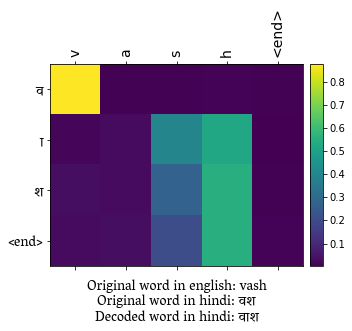

Original word in english: fatma
Original word in hindi: फातमा
Decoded word in hindi: फटमा


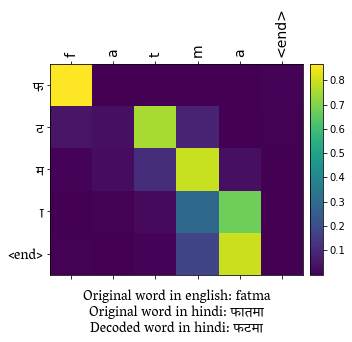

Original word in english: phalitartha
Original word in hindi: फलितार्थ
Decoded word in hindi: फलितर्था


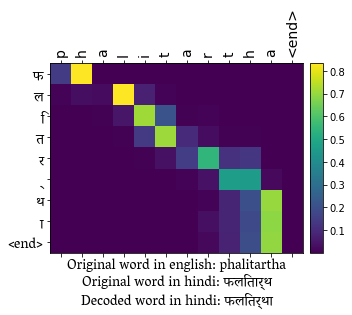

Original word in english: bagali
Original word in hindi: बागली
Decoded word in hindi: बगली


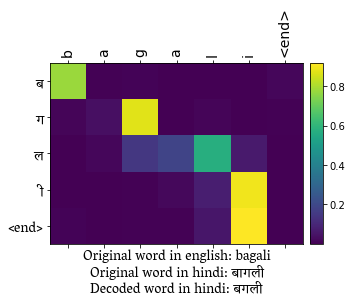

Original word in english: barasingha
Original word in hindi: बारहसिंगा
Decoded word in hindi: बरसिंह


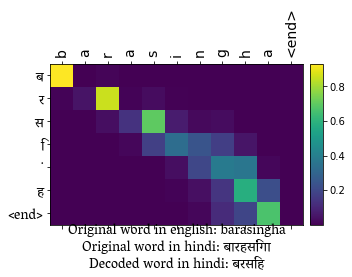

Original word in english: pigs
Original word in hindi: पिग्स
Decoded word in hindi: पिग्स


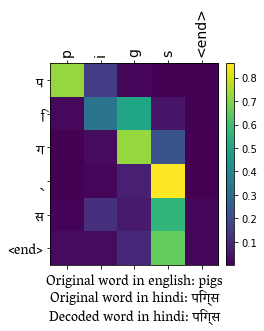

Original word in english: rajinama
Original word in hindi: राजीनामा
Decoded word in hindi: राजीनमा


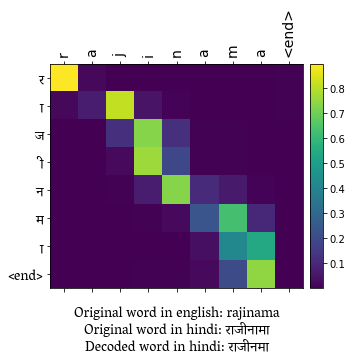

Original word in english: karur
Original word in hindi: करूर
Decoded word in hindi: करूर


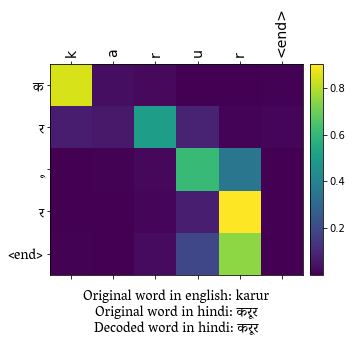

Original word in english: bewakoofaanaa
Original word in hindi: बेवकूफाना
Decoded word in hindi: बेवकूफाना


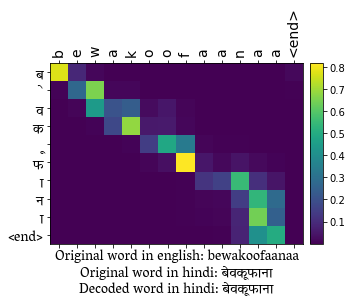

Original word in english: mahamantr
Original word in hindi: महामंत्र
Decoded word in hindi: महामंत्र


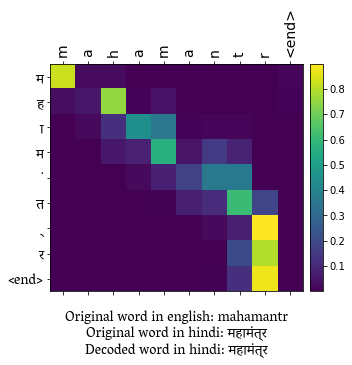

In [161]:
val = df.values

for _ in range(10):
    sp = np.random.choice(val.shape[0])

    output = [x for x in val[sp][2].strip()] + ['<end>']
    input = [x for x in val[sp][0].strip()] + ['<end>']

    plot = weights[sp][0][:len(input),:len(output)].T

    print("Original word in english:", val[sp][0])
    print("Original word in hindi:", val[sp][1])
    print("Decoded word in hindi:", val[sp][2])

    plot_attention(plot, input, output,val[sp][0],val[sp][1],val[sp][2])

Q6

In [55]:
from IPython.display import HTML as html_print
from IPython.display import display

In [162]:
# get appropriate color for value
def get_clr(value):
    colors = ['#85c2e1', '#89c4e2', '#95cae5', '#99cce6', '#a1d0e8'
        '#b2d9ec', '#baddee', '#c2e1f0', '#eff7fb', '#f9e8e8',
        '#f9e8e8', '#f9d4d4', '#f9bdbd', '#f8a8a8', '#f68f8f',
        '#f47676', '#f45f5f', '#f34343', '#f33b3b', '#f42e2e']
    value = max(0,min(int((value * 100) / 5),19))
    return colors[value]

In [163]:
# get html element
def cstr(s, color='black'):
    if s == ' ':
        return "<text style=color:#000;padding-left:10px;background-color:{}> </text>".format(color, s)
    else:
        return "<text style=color:#000;background-color:{}>{} </text>".format(color, s)

In [164]:
# print html
def print_color(t,ch):
    display(html_print(''.join([cstr(ch,color='#fffff')]+[cstr(' ',color='#fffff') for _ in range(3)]+[cstr(ti, color=ci) for ti,ci in t])))

In [172]:
index = np.random.choice(len(val))
#visualise_word(ex,0)
word = val[index][2]
source = val[index][0]
attwts = weights[index][0][:len(source),:]
print("Original word in english:",source)
print("Decoded word in hindi:",word)
# visualize the words
for i in range(len(word)):
    text_colours = []
    for j in range(len(attwts[:,i])):
        text = (source[j], get_clr(attwts[:,i][j]))
        text_colours.append(text)
    print_color(text_colours,word[i])

Original word in english: virodhabhasi
Decoded word in hindi: विरोधाभासी
